In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
!ls

 3_29_2021_dry_run_1.ipynb			    4_1_2021_with_png.ipynb
 3_29_2021_dry_run.ipynb			    class_map_corrected.csv
 3_30_2021_dry_run.ipynb			    kalpurush-2.ttf
 3_31_2021_dry_run-more_layers_n_pools.ipynb	    logs
 3_31_2021_dry_run_with_layer_learning_rate.ipynb   logs_3
 3_31_2021_resnet50.ipynb			    model.png
'3_31_night_thanks_to_Kaushal Shah.ipynb'	    sample_submission.csv
 4_1_2021_dry_run.ipynb				    test.csv
 4_1_2021_with_png_experiment_pm.ipynb		    train.csv


In [3]:
df_index=pd.read_csv('train.csv')
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [4]:
df_index.shape

(200840, 5)

<AxesSubplot:>

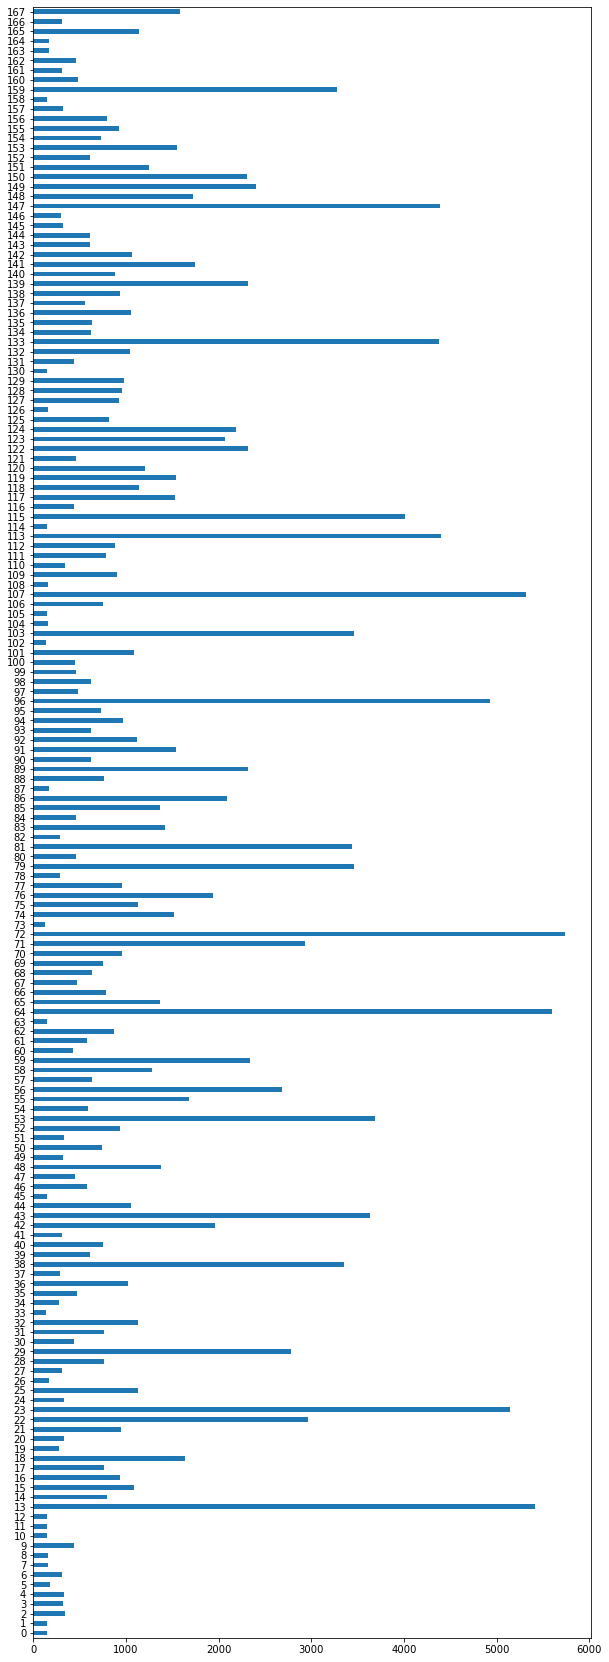

In [5]:
plt.figure(figsize=(10,30))
df_index['grapheme_root'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

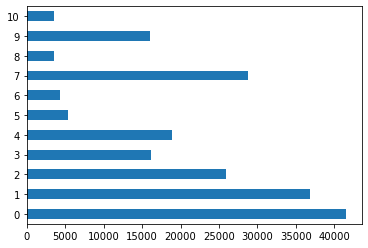

In [6]:
df_index['vowel_diacritic'].value_counts().sort_index().plot.barh()  

<AxesSubplot:>

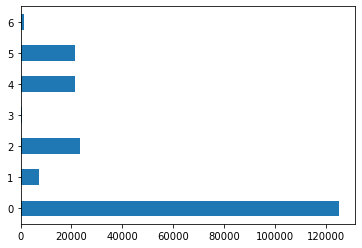

In [7]:
df_index['consonant_diacritic'].value_counts().sort_index().plot.barh()  

In [8]:
df_index['image_id']=df_index['image_id']+'.png'

In [9]:
df_index

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো
1,Train_1.png,159,0,0,হ
2,Train_2.png,22,3,5,খ্রী
3,Train_3.png,53,2,2,র্টি
4,Train_4.png,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835.png,22,7,2,র্খে
200836,Train_200836.png,65,9,0,ত্তো
200837,Train_200837.png,2,1,4,অ্যা
200838,Train_200838.png,152,9,0,স্নো


In [10]:
df_index['consonant_diacritic'].value_counts() 
#7 values , # 7 columns one hot coding, output = 7 colums and softmax

0    125278
2     23465
5     21397
4     21270
1      7424
6      1387
3       619
Name: consonant_diacritic, dtype: int64

In [11]:
df_index.dtypes

image_id               object
grapheme_root           int64
vowel_diacritic         int64
consonant_diacritic     int64
grapheme               object
dtype: object

In [30]:
df_shuffle = df_index.sample(frac=1) #shuffle

In [31]:
train = df_shuffle.iloc[:int(0.8*len(df_index)),:]
test = df_shuffle.iloc[int(0.8*len(df_index)):,:]

In [34]:
len(train)

160672

In [35]:
len(test)

40168

In [32]:
train.sample().shape

(1, 5)

In [33]:
128*128

16384

In [16]:
df_index.head(1)

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0.png,15,9,5,ক্ট্রো


In [17]:
from PIL import Image 

def mygenerator1(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y1=np.zeros(7)
        y1[sample["consonant_diacritic"].values[0]]=1  
        y1 = y1.astype(np.int32).reshape(1,7) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y1
# infinite numbers of X and y    

In [18]:
from PIL import Image 

def mygenerator2(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)
        y2=np.zeros(11)
        y2[sample["vowel_diacritic"].values[0]]=1  
        y2 = y2.astype(np.int32).reshape(1,11) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)

        yield X,y2
# infinite numbers of X and y    

In [19]:
from PIL import Image 

def mygenerator3(dataframe): # X = image, y = target
    while True:
        sample = dataframe.sample()
        TRAIN_DIR = '/home/beth/Galvanize/capstone/capstone_2_new/capstone_2/train_img/img/'
        image_name = TRAIN_DIR + sample['image_id'].values[0]
        image=Image.open(image_name)
        X = np.array(image).astype(np.int32)
        X = X.reshape(1,128,128,1)        
        y3=np.zeros(168)
        y3[sample["grapheme_root"].values[0]]=1  
        y3 = y3.astype(np.int32).reshape(1,168) 
#         X = np.array([X,X,X]).reshape(1,137,236,3)
        yield X,y3
# infinite numbers of X and y    

In [20]:
X,y1 = next(mygenerator1(train)) # randomly pick a row 

In [21]:
X.shape

(1, 128, 128, 1)

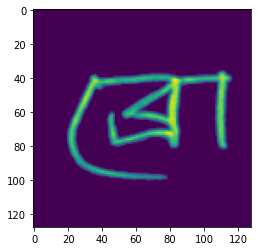

In [22]:
plt.imshow(X[0,:,:,0])

In [23]:
X,y2 = next(mygenerator1(train)) # randomly pick a row X,y1

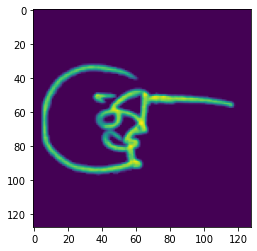

In [24]:
plt.imshow(X[0,:,:,0])

In [25]:
X,y2 = next(mygenerator1(train)) # randomly pick a row X,y1

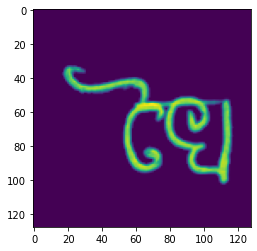

In [26]:
plt.imshow(X[0,:,:,0])

In [ ]:
# https://www.kaggle.com/iafoss/image-preprocessing-128x128?select=train.zip

# Image preprocessing (128x128)

In [ ]:
# import cv2
# from tqdm import tqdm_notebook as tqdm
# import zipfile
# import io
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# HEIGHT = 137
# WIDTH = 236
# SIZE = 128

# TRAIN = ['/kaggle/input/bengaliai-cv19/train_image_data_0.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_1.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_2.parquet',
#          '/kaggle/input/bengaliai-cv19/train_image_data_3.parquet']

# OUT_TRAIN = 'train.zip'

In [ ]:
# def bbox(img):
#     rows = np.any(img, axis=1)
#     cols = np.any(img, axis=0)
#     rmin, rmax = np.where(rows)[0][[0, -1]]
#     cmin, cmax = np.where(cols)[0][[0, -1]]
#     return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=SIZE, pad=16):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

In [ ]:
# df = pd.read_parquet(TRAIN[0])
# n_imgs = 8
# fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

# for idx in range(n_imgs):
#     #somehow the original input is inverted
#     img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
#     #normalize each image by its max val
#     img = (img0*(255.0/img0.max())).astype(np.uint8)
#     img = crop_resize(img)

#     axs[idx,0].imshow(img0)
#     axs[idx,0].set_title('Original image')
#     axs[idx,0].axis('off')
#     axs[idx,1].imshow(img)
#     axs[idx,1].set_title('Crop & resize')
#     axs[idx,1].axis('off')
# plt.show()

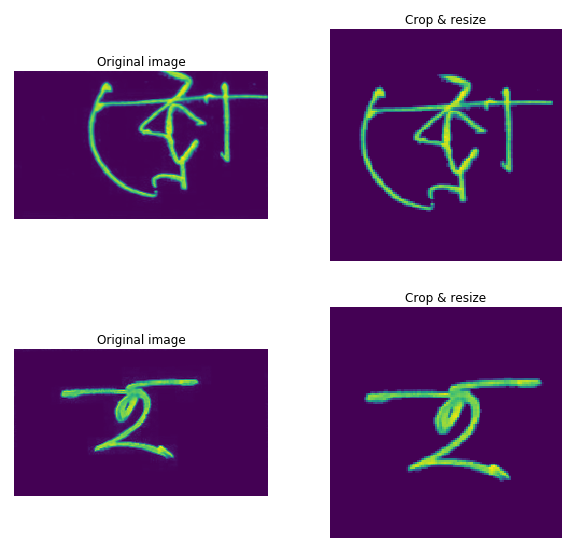

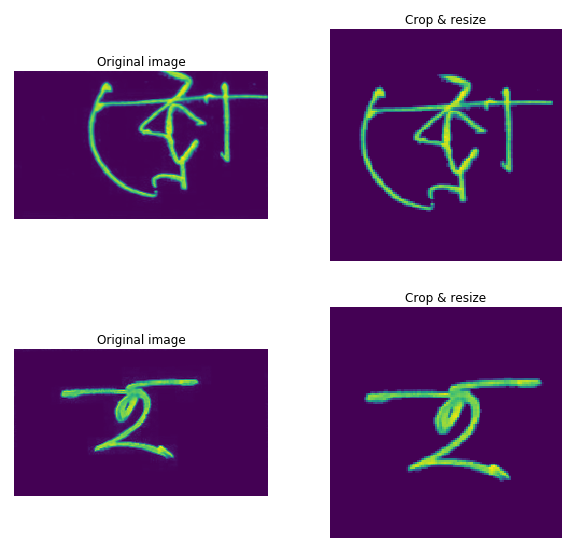

In [ ]:
# x_tot,x2_tot = [],[]
# with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out:
#     for fname in TRAIN:
#         df = pd.read_parquet(fname)
#         #the input is inverted
#         data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
#         for idx in tqdm(range(len(df))):
#             name = df.iloc[idx,0]
#             #normalize each image by its max val
#             img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
#             img = crop_resize(img)
        
#             x_tot.append((img/255.0).mean())
#             x2_tot.append(((img/255.0)**2).mean()) 
#             img = cv2.imencode('.png',img)[1]
#             img_out.writestr(name + '.png', img)

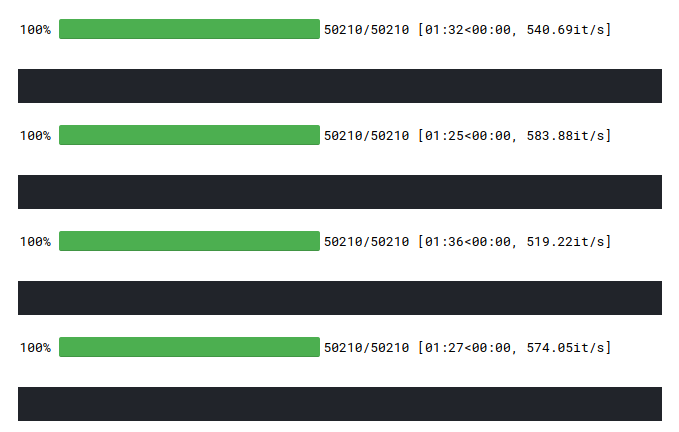

4_1_2021_ 

- Previously I got horrible scores 

    * consonant_diacritic : 
        * Test score: 2.7546441555023193
        * Test accuracy: 0.6499999761581421

    * vowel_diacritic : 
        * Test score: 1.8599588871002197
        * Test accuracy: 0.5040000081062317

    * grapheme_root : 
        * Test score: 4.7975382804870605
        * Test accuracy: 0.02500000037252903



maybe it was too deep?

- reduced layers
- reduced normalization 
- decreased learning rate from 0.0001 to 0.00001
- training epochs = 30/ steps = 180
- testing steps = 30 


- This time I am doing much better 

    * consonant_diacritic :
        * Test score: 0.8095945119857788
        * Test accuracy: 0.7200000286102295

    * vowel_diacritic : 
        * Test score: 1.0902100801467896
        * Test accuracy: 0.6190000176429749

    * grapheme_root :         
        * Test score: 4.837403774261475
        * Test accuracy: 0.02500000037252903


# consonant_diacritic

In [63]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(7, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [64]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 32, 32, 64)      

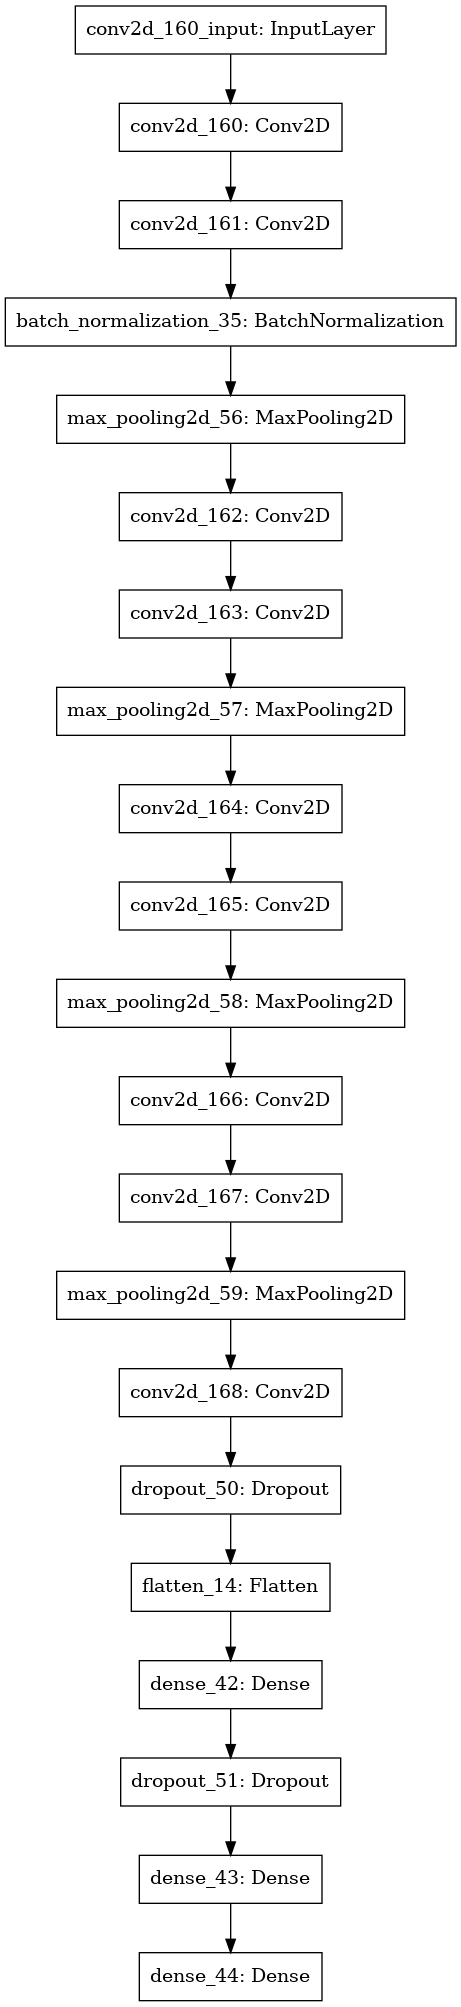

In [65]:
from keras.utils import plot_model
plot_model(model)

In [67]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs')]

history = model.fit(mygenerator1(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator1(test),
                    validation_steps=180, 
                    callbacks=my_callbacks)              


Epoch 1/30
180/180 [==============================] - 22s 120ms/step - loss: 0.9129 - accuracy: 0.7056 - recall_13: 0.6667 - val_loss: 1.2727 - val_accuracy: 0.6944 - val_recall_13: 0.6944
Epoch 2/30
180/180 [==============================] - 24s 135ms/step - loss: 0.9298 - accuracy: 0.7056 - recall_13: 0.6556 - val_loss: 1.0588 - val_accuracy: 0.6611 - val_recall_13: 0.5833
Epoch 3/30
180/180 [==============================] - 24s 134ms/step - loss: 1.1949 - accuracy: 0.5833 - recall_13: 0.4444 - val_loss: 1.0606 - val_accuracy: 0.6444 - val_recall_13: 0.4444
Epoch 4/30
180/180 [==============================] - 24s 132ms/step - loss: 1.0142 - accuracy: 0.6722 - recall_13: 0.6056 - val_loss: 0.8711 - val_accuracy: 0.7333 - val_recall_13: 0.7056
Epoch 5/30
180/180 [==============================] - 23s 129ms/step - loss: 1.0334 - accuracy: 0.6722 - recall_13: 0.5444 - val_loss: 1.1053 - val_accuracy: 0.6389 - val_recall_13: 0.6167
Epoch 6/30
180/180 [==============================] - 2

In [68]:
score = model.evaluate(mygenerator1(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 0.8095945119857788
Test accuracy: 0.7200000286102295


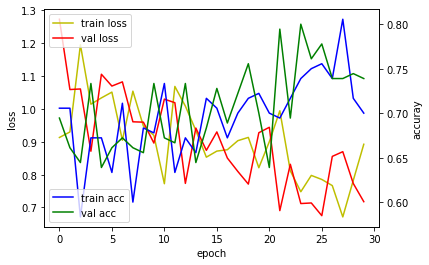

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [70]:
prediction = [] 
actual = []
for x,y in mygenerator1(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [71]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
multiclass=confusion_matrix(actual, prediction)
print(multiclass)

Confusion Matrix
[[632   0  13   0   3   1   0]
 [ 31   0   1   0   0   0   0]
 [ 41   0  79   0   0   0   0]
 [  1   0   0   0   1   0   0]
 [ 48   0   1   0  45   1   0]
 [ 94   0   0   0   0   4   0]
 [  3   0   0   0   2   0   0]]


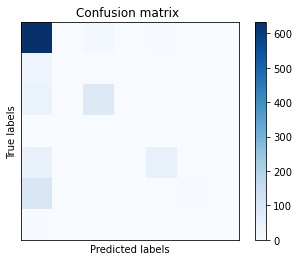

In [72]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# vowel_diacritic

In [73]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(11, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [74]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_169 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 32, 32, 64)      

In [75]:
my_callbacks_2 = [
    keras.callbacks.EarlyStopping(patience=100),
    keras.callbacks.TensorBoard(log_dir='./logs_2')]

history = model.fit(mygenerator2(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator2(test),
                    validation_steps=180, 
                    callbacks=my_callbacks_2)                 


Epoch 1/30
180/180 [==============================] - 23s 123ms/step - loss: 2.3113 - accuracy: 0.1355 - recall_14: 0.0000e+00 - val_loss: 2.1616 - val_accuracy: 0.2556 - val_recall_14: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 23s 130ms/step - loss: 2.1678 - accuracy: 0.2014 - recall_14: 0.0000e+00 - val_loss: 2.0496 - val_accuracy: 0.2500 - val_recall_14: 0.0000e+00
Epoch 3/30
180/180 [==============================] - 23s 130ms/step - loss: 2.0294 - accuracy: 0.2348 - recall_14: 0.0000e+00 - val_loss: 2.1164 - val_accuracy: 0.2611 - val_recall_14: 0.0000e+00
Epoch 4/30
180/180 [==============================] - 23s 129ms/step - loss: 1.9148 - accuracy: 0.3013 - recall_14: 0.0033 - val_loss: 1.9035 - val_accuracy: 0.3611 - val_recall_14: 0.0444
Epoch 5/30
180/180 [==============================] - 23s 130ms/step - loss: 1.8478 - accuracy: 0.3287 - recall_14: 1.2329e-04 - val_loss: 2.0799 - val_accuracy: 0.2611 - val_recall_14: 0.0333
Epoch 6/30
180/180 [=======

In [76]:
score = model.evaluate(mygenerator2(test), steps=1000,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 1.0902100801467896
Test accuracy: 0.6190000176429749


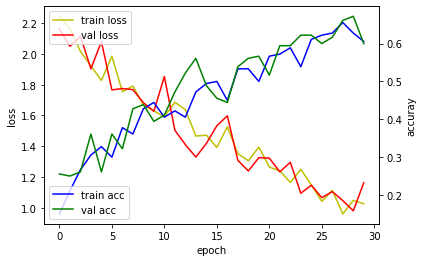

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [183]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [78]:
prediction = [] 
actual = []
for x,y in mygenerator2(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [79]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Confusion Matrix
[[184   9   5   0   6   0   3   8   0   0   0]
 [ 78  94   1   7   0   0   0   5   1   2   1]
 [ 17   0 113   0   1   0   0   0   2   0   0]
 [ 18   7   1  46   0   0   1   1   0   0   2]
 [ 35   0   0   0  53   0  12   6   0   0   0]
 [  5   0   0   0   2   0   7   0   0   0   0]
 [  9   0   0   0   3   0  11   0   0   0   0]
 [ 22   0   2   0   0   0   0 112   0   4   0]
 [  0   0   0   0   1   0   0   2   7   0   0]
 [  2   2   2   0   0   0   0  36   0  33   0]
 [  0   0   1   1   1   0   0  13   1   0   3]]


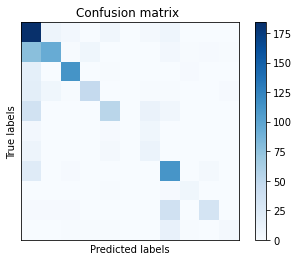

In [80]:
cm = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# grapheme_root

In [81]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(128,128,1)), 
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.BatchNormalization(momentum=0.15),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'),
    keras.layers.Dropout(rate=0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation = "relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(512, activation = "relu"),
    keras.layers.Dense(168, activation = 'softmax')   
])

opt = keras.optimizers.Adam(learning_rate=0.00001)  # <--------------------------
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', keras.metrics.Recall()])


In [82]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 32, 32, 64)      

In [83]:
my_callbacks_3 = [keras.callbacks.EarlyStopping(patience=100),
                  keras.callbacks.TensorBoard(log_dir='./logs_3')]

history = model.fit(mygenerator3(train),
                    epochs=30,
                    steps_per_epoch=180, 
                    validation_data=mygenerator3(test),
                    validation_steps=180, 
                    callbacks=my_callbacks_3)                 


Epoch 1/30
180/180 [==============================] - 23s 122ms/step - loss: 5.1026 - accuracy: 0.0168 - recall_15: 0.0000e+00 - val_loss: 5.0074 - val_accuracy: 0.0278 - val_recall_15: 0.0000e+00
Epoch 2/30
180/180 [==============================] - 24s 133ms/step - loss: 4.9533 - accuracy: 0.0358 - recall_15: 0.0000e+00 - val_loss: 5.0080 - val_accuracy: 0.0111 - val_recall_15: 0.0000e+00
Epoch 3/30
180/180 [==============================] - 24s 134ms/step - loss: 4.7812 - accuracy: 0.0631 - recall_15: 0.0000e+00 - val_loss: 4.9741 - val_accuracy: 0.0222 - val_recall_15: 0.0000e+00
Epoch 4/30
180/180 [==============================] - 24s 131ms/step - loss: 4.9243 - accuracy: 0.0179 - recall_15: 0.0000e+00 - val_loss: 4.8237 - val_accuracy: 0.0389 - val_recall_15: 0.0000e+00
Epoch 5/30
180/180 [==============================] - 24s 131ms/step - loss: 4.7808 - accuracy: 0.0622 - recall_15: 0.0000e+00 - val_loss: 4.8456 - val_accuracy: 0.0333 - val_recall_15: 0.0000e+00
Epoch 6/30
180/

In [84]:
score = model.evaluate(mygenerator3(test), steps=200,verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 4.837403774261475
Test accuracy: 0.02500000037252903


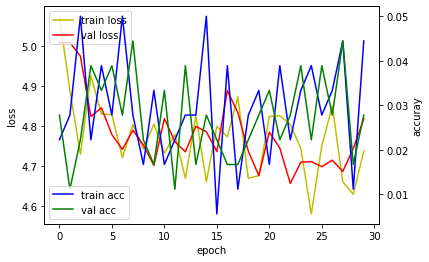

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


In [187]:
# [plt.plot(history.history[i], label=i) for i in history.history.keys()]
# plt.legend();

In [86]:
prediction = [] 
actual = []
for x,y in mygenerator3(test):
#     plt.imshow(x[0,:,:,0])
    actual.append(y.argmax())
    prediction.append(model.predict(x).argmax())
    if len(actual)>1000:
        break     

In [87]:
len(actual)

1001

In [88]:
len(prediction)

1001

In [89]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cm=confusion_matrix(actual, prediction)
print(cm)

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


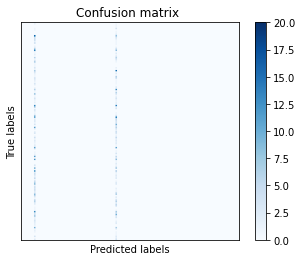

In [90]:
multiclass = confusion_matrix(actual, prediction)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()


# NOT GOOD


consonant_diacritic

- Test score: 2.7546441555023193
- Test accuracy: 0.6499999761581421


vowel_diacritic

- Test score: 1.8599588871002197
- Test accuracy: 0.5040000081062317


grapheme_root

- Test score: 4.7975382804870605
- Test accuracy: 0.02500000037252903
